# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1SIZo5Udb2uev-aKIsFTxZKVtonlT6Jao/view?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-ae8c282112b0>:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
# A report of the min, max, mean, and the basic info about the required columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
yredu,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capgain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
caploss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
workhr,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [ ]:
# To normalized the specific columns in range [0,1]

# List of columns to normalize
columns_to_normalize = ["age", "yredu", "capgain", "caploss", "workhr"]

# Initialize the MinMaxScaler normalizing features within the range 0 to 1
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

652.5941230486685

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
# Get the count of each unique value in the 'gender' column
gender_counts = df['sex'].value_counts(normalize=True)

# The normalized counts are in proportion, so we multiply by 100 to get the percentage
percentage_males = gender_counts[' Male'] * 100

print(f"Percentage of males in the dataset: {percentage_males}%")

Percentage of males in the dataset: 66.92054912318419%


In [ ]:
# Get the count of each unique value in the 'gender' column
gender_counts = df['sex'].value_counts(normalize=True)

# The normalized counts are in proportion, so we multiply by 100 to get the percentage
percentage_females = gender_counts[' Female'] * 100

print(f"Percentage of females in the dataset: {percentage_females}%")

Percentage of females in the dataset: 33.07945087681583%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
# Sanity check
missing_num = df_with_missing.shape[0]
not_missing_num = df_not_missing.shape[0]

percent_removed = (missing_num/not_missing_num)*100

print(f"There are {missing_num} records contained missing features. ")
print(f"{percent_removed}% of records were removed.")

There are 1843 records contained missing features. 
5.999739566378019% of records were removed.


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
df_not_missing.work.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
column_names = data.columns.tolist()
print(column_names)

['age', 'yredu', 'capgain', 'caploss', 'workhr', 'work_ Federal-gov', 'work_ Local-gov', 'work_ Private', 'work_ Self-emp-inc', 'work_ Self-emp-not-inc', 'work_ State-gov', 'work_ Without-pay', 'marriage_ Divorced', 'marriage_ Married-AF-spouse', 'marriage_ Married-civ-spouse', 'marriage_ Married-spouse-absent', 'marriage_ Never-married', 'marriage_ Separated', 'marriage_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'edu_ 10th', 'edu_ 11th', 'edu_ 12th', 'edu_ 1st-4th', 'edu_ 5th-6th', 'edu_ 7th-8th', 'edu_ 9th', 'edu_ Assoc-acdm', 'edu_ Assoc-voc', 'edu_ Bachelors', 'edu_ Doctorate', 'edu_ HS-grad', 'edu_ Masters

### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
# check
print(f"The 'data' dataframe contains {data.shape[1]} columns.")
print("These 57 columns are from the original numerical columns, and new the columns are added for our purpose of one-hot encoding.")

The 'data' dataframe contains 57 columns.
These 57 columns are from the original numerical columns, and new the columns are added for our purpose of one-hot encoding.


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [" " + value]
        else:
            cat_values[feature].append(" " + value)

In [ ]:
print(cat_index)
print(cat_values)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': [' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'], 'marriage': [' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'], 'occupation': [' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'], 'edu': [' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'], 'relationship': [' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife'], 'sex': [' Female', ' Male']}


In [ ]:
def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

In [ ]:
value = cat_values["work"]
print(value)

[' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay']


In [ ]:
def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    index_mapping = np.argmax(onehot)
    value = cat_values[feature]
    return value[index_mapping]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo - we want ~70% training, ~15% validation, ~15% testing
# First, split into training and temporary test set with 70-30 split
train_set, temp_test_set = train_test_split(datanp, test_size=0.3, random_state=50)

# Now split the temporary test set into validation and test set with a 50-50 split
val_set, test_set = train_test_split(temp_test_set, test_size=0.5, random_state=50)

# Report the number of items in each set
num_train = train_set.shape[0]
num_validation = val_set.shape[0]
num_test = test_set.shape[0]

num_total = num_train + num_validation + num_test

print(f"Number of items in training set: {num_train}   --> {num_train*100/num_total}%")
print(f"Number of items in validation set: {num_validation}  --> {num_validation*100/num_total}%")
print(f"Number of items in test set: {num_test}        --> {num_test*100/num_total}%")

Number of items in training set: 21502   --> 69.99804674783515%
Number of items in validation set: 4608  --> 15.000976626082426%
Number of items in test set: 4608        --> 15.000976626082426%


In [ ]:
val_set.shape

(4608, 57)

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 64), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Since our input are all normalised to in range between [0,1], we want to reconstruct our ouput to also be in this range between [0,1]. The `sigmoid function` is there to get the our output from the decoder to be in the range [0,1].

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # traning parameter to return
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # Let's get started
    print ("Training Started...")
    start_time = time.time()

    for epoch in range(num_epochs):
        total_loss = 0
        iteration = 0

        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            reconstructed = model(datam)
            loss = criterion(reconstructed, data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # to update paramters for returning paramters
            total_loss += loss.item()
            iteration += 1

        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        train_loss[epoch] = total_loss/(iteration + 1)
        val_loss[epoch] = get_loss(model, valid_loader, criterion)

        print(f"epoch: {epoch}  |  training acc: {train_acc[epoch]}  |  validation acc: {val_acc[epoch]}")

    epochs = np.arange(1, num_epochs + 1)

    print('\nFinished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total training time used: {:.2f} seconds".format(elapsed_time))

    return train_acc, val_acc, train_loss, val_loss, epochs

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0

    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1

    return acc / total

In [ ]:
def get_loss(model, data_loader, criterion):
    """
    Function:
        - Return the "loss" of the autoencoder model across a data set.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader
       - criterion: the specific loss function we decided to utilize
    Note:
        In each iteration, we will hide one of the categorical
        features using the zero_out_random_features function.
    """

    total_loss = 0
    iterations = 0

    for data in data_loader:
        provided = zero_out_random_feature(data.clone()) # to randomly hide one of the categorical features
        reconstructed = model(provided)
        loss = criterion(reconstructed, data)

        total_loss += loss.item()
        iterations += 1

    return total_loss/(iterations + 1)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [ ]:
# loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=1)

# initializing
auto = AutoEncoder()

# training
train_acc, val_acc, train_loss, val_loss, epochs = train(auto, train_loader, val_loader, num_epochs=30)

Training Started...
epoch: 0  |  training acc: 0.45987194989613367  |  validation acc: 0.4542100694444444
epoch: 1  |  training acc: 0.4577326140204012  |  validation acc: 0.4525462962962963
epoch: 2  |  training acc: 0.45754658481381577  |  validation acc: 0.4529079861111111
epoch: 3  |  training acc: 0.45763959941710847  |  validation acc: 0.45417390046296297
epoch: 4  |  training acc: 0.5169209065823335  |  validation acc: 0.5102358217592593
epoch: 5  |  training acc: 0.5466313211174154  |  validation acc: 0.5419560185185185
epoch: 6  |  training acc: 0.5690323380770781  |  validation acc: 0.5652126736111112
epoch: 7  |  training acc: 0.5726754100393762  |  validation acc: 0.5694806134259259
epoch: 8  |  training acc: 0.5737760828450067  |  validation acc: 0.5713614004629629
epoch: 9  |  training acc: 0.5761014479273245  |  validation acc: 0.5754484953703703
epoch: 10  |  training acc: 0.579783275974328  |  validation acc: 0.5787398726851852
epoch: 11  |  training acc: 0.58126375841

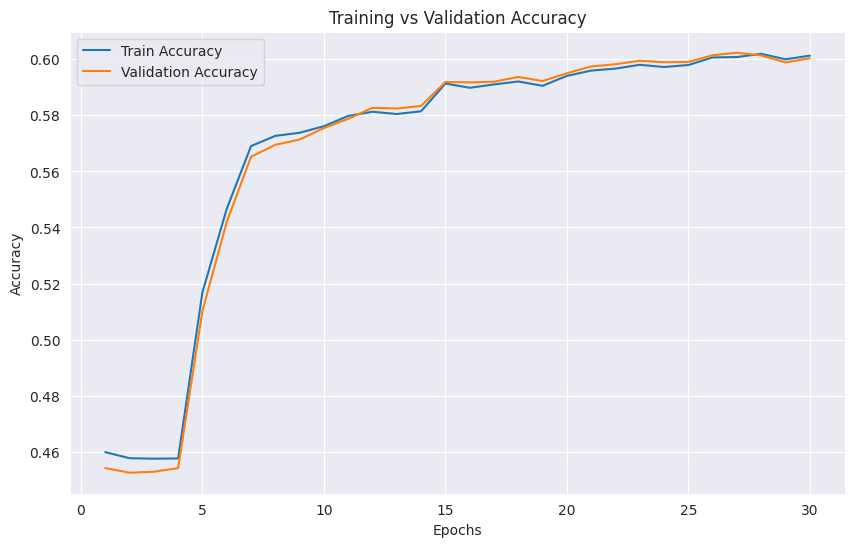

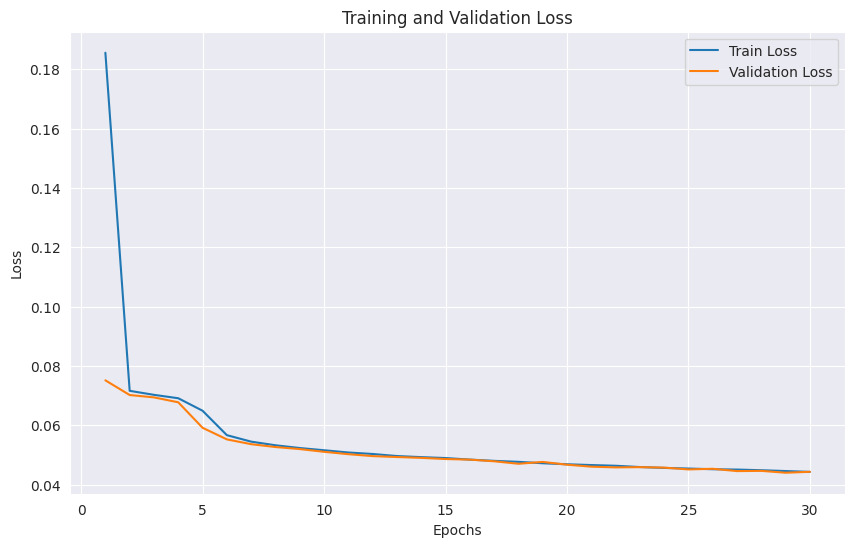

In [ ]:
# visualizing
# Set the aesthetic style of the plots
sns.set_style("darkgrid")

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=train_acc, label="Train Accuracy")
sns.lineplot(x=epochs, y=val_acc, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Combined Training and Validation Loss
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=train_loss, label="Train Loss")
sns.lineplot(x=epochs, y=val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

**Trail: 1**
- Batch Size: 64
- Epochs: 30
- Learning Rate: 1e-5

`Result: 1`
- Training Accuracy: 0.46194152481939665
- Validation Accuracy: 0.4575737847222222

`Thoughts:`
- I decided to lower the learning rate since I noticed that in the default training parameters, the accuracy quickly reached to ~0.55 in 5 epochs and it then increased very slowly to reach the final accuracy of ~0.6.

- However, it seems that the learning rate is too slow now, and the model is not able to learn as much as with the default parameters.

- So next, let's try to increase the learning rate a little bit higher and increase the number of epochs.

In [ ]:
# loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=1)

# initializing
auto_1 = AutoEncoder()
# training
train_acc, val_acc, train_loss, val_loss, epochs = train(auto_1, train_loader, val_loader, num_epochs=30, learning_rate=1e-5)

Training Started...
epoch: 0  |  training acc: 0.27867950268192104  |  validation acc: 0.2760054976851852
epoch: 1  |  training acc: 0.2954608873593154  |  validation acc: 0.29170283564814814
epoch: 2  |  training acc: 0.3543236288097231  |  validation acc: 0.35065827546296297
epoch: 3  |  training acc: 0.3543236288097231  |  validation acc: 0.35065827546296297
epoch: 4  |  training acc: 0.35661023780733575  |  validation acc: 0.3521773726851852
epoch: 5  |  training acc: 0.3673224196198803  |  validation acc: 0.36494502314814814
epoch: 6  |  training acc: 0.4242008495333767  |  validation acc: 0.42006655092592593
epoch: 7  |  training acc: 0.4064273090875267  |  validation acc: 0.4044053819444444
epoch: 8  |  training acc: 0.4079775524757387  |  validation acc: 0.40599681712962965
epoch: 9  |  training acc: 0.4577481164542833  |  validation acc: 0.4547164351851852
epoch: 10  |  training acc: 0.4577481164542833  |  validation acc: 0.4547164351851852
epoch: 11  |  training acc: 0.457748

**Trail: 2**
- Batch Size: 64
- Epochs: 50
- Learning Rate: 5e-5

`Result: 2`
- Training Accuracy: 0.5965569094347812
- Validation Accuracy: 0.5965350115740741

`Thoughts:`
- Although the final accuracy does improve from trial 1 with a larger learning rate and more epochs of training, it seems that there is a bottleneck for the accuracy of our model at ~0.6.

- So next, let's try to decrease the batch size and increase the learning rate a little bit higher.


In [ ]:
# loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=1)

# initializing
auto_2 = AutoEncoder()
# training
train_acc, val_acc, train_loss, val_loss, epochs = train(auto_2, train_loader, val_loader, num_epochs=50, learning_rate=5e-5)

Training Started...
epoch: 0  |  training acc: 0.26510712181812546  |  validation acc: 0.26634837962962965
epoch: 1  |  training acc: 0.45672495581806344  |  validation acc: 0.45363136574074076
epoch: 2  |  training acc: 0.45672495581806344  |  validation acc: 0.45363136574074076
epoch: 3  |  training acc: 0.45911233063590984  |  validation acc: 0.4538845486111111
epoch: 4  |  training acc: 0.45942237931355223  |  validation acc: 0.45384837962962965
epoch: 5  |  training acc: 0.4578876383592224  |  validation acc: 0.453125
epoch: 6  |  training acc: 0.4574380677766409  |  validation acc: 0.4530164930555556
epoch: 7  |  training acc: 0.4575310823799337  |  validation acc: 0.4530164930555556
epoch: 8  |  training acc: 0.4572287849192323  |  validation acc: 0.4530164930555556
epoch: 9  |  training acc: 0.46771618144048616  |  validation acc: 0.46469907407407407
epoch: 10  |  training acc: 0.4985427712150808  |  validation acc: 0.4920789930555556
epoch: 11  |  training acc: 0.5262223669116

**Trail: 3**
- Batch Size: 32
- Epochs: 50
- Learning Rate: 8e-5

`Result: 3`
- Training Accuracy: 0.6192757262890274  
- Validation Accuracy: 0.6148003472222222

`Thoughts:`
- The accuracy is improved and it is higher than the previous results, but it takes almost double the time to train the model.

- So next, let's try to use the default 30 training epochs, and push the learning rate higher than the default one.

In [ ]:
# loading
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=1)

# initializing
auto_3 = AutoEncoder()
# training
train_acc, val_acc, train_loss, val_loss, epochs = train(auto_3, train_loader, val_loader, num_epochs=50, learning_rate=8e-5)

Training Started...
epoch: 0  |  training acc: 0.4595308963507271  |  validation acc: 0.45504195601851855
epoch: 1  |  training acc: 0.45987194989613367  |  validation acc: 0.4542100694444444
epoch: 2  |  training acc: 0.4740644281152141  |  validation acc: 0.4701244212962963
epoch: 3  |  training acc: 0.5470343843983505  |  validation acc: 0.5416666666666666
epoch: 4  |  training acc: 0.5659628561684185  |  validation acc: 0.5622829861111112
epoch: 5  |  training acc: 0.5718150249589186  |  validation acc: 0.5685763888888888
epoch: 6  |  training acc: 0.5790391591479862  |  validation acc: 0.5763165509259259
epoch: 7  |  training acc: 0.58082193904443  |  validation acc: 0.5787760416666666
epoch: 8  |  training acc: 0.5806746659225498  |  validation acc: 0.5803313078703703
epoch: 9  |  training acc: 0.5846355377794313  |  validation acc: 0.5843460648148148
epoch: 10  |  training acc: 0.5847828109013115  |  validation acc: 0.5840567129629629
epoch: 11  |  training acc: 0.58455027439307

**Trail: 4**
- Batch Size: 32
- Epochs: 30
- Learning Rate: 3e-4

`Result: 4`
- Training Accuracy: 0.6224149691501566
- Validation Accuracy: 0.6191767939814815

`Thoughts:`
- The accuracy is improved with less time required for training the autoencoder model.

- Plus, it provided the highest validation accuracy among all the trials. We will use it for the following sections as the best-trained autoencoder.

In [ ]:
# loading
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=1)

# initializing
auto_4 = AutoEncoder()
# training
train_acc, val_acc, train_loss, val_loss, epochs = train(auto_4, train_loader, val_loader, num_epochs=30, learning_rate=3e-4)

Training Started...
epoch: 0  |  training acc: 0.5123011812854619  |  validation acc: 0.5067274305555556
epoch: 1  |  training acc: 0.5753573311009829  |  validation acc: 0.5725911458333334
epoch: 2  |  training acc: 0.5787058568195207  |  validation acc: 0.5774016203703703
epoch: 3  |  training acc: 0.5964406411806653  |  validation acc: 0.5950159143518519
epoch: 4  |  training acc: 0.6049747310327721  |  validation acc: 0.6041666666666666
epoch: 5  |  training acc: 0.6061374135739311  |  validation acc: 0.6032986111111112
epoch: 6  |  training acc: 0.605734350292996  |  validation acc: 0.6024305555555556
epoch: 7  |  training acc: 0.6056413356897032  |  validation acc: 0.6022497106481481
epoch: 8  |  training acc: 0.6099742659597557  |  validation acc: 0.6057942708333334
epoch: 9  |  training acc: 0.6118423092425511  |  validation acc: 0.6082175925925926
epoch: 10  |  training acc: 0.6127259479738318  |  validation acc: 0.6098090277777778
epoch: 11  |  training acc: 0.613415806281586

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
auto_acc = get_accuracy(auto_4, test_loader)

In [ ]:
print(auto_acc)

0.6238425925925926


`Result:`
- The test accuracy is even higher than the validation accuracy and reached to ~0.624.

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
# To define our baseline model
def baseline_model(record):
    # Iterate through each categorical column
    for col in catcols:
        # Check if the feature is missing in the input vector (i.e., all one-hot encoded entries are 0)
        if (np.sum(get_onehot(record, col)) == 0):
            # Retrieve the mode for this column from the precomputed dictionary
            mode = str(most_common[col])
            # Create a zero vector for one-hot encoding of the correct size for the feature
            pred = np.zeros(len(cat_values[col]))
            # Set the index for the mode to 1 in the one-hot encoded vector
            pred[cat_values[col].index(mode)] = 1

            # Replace the corresponding part of the input vector with the one-hot encoded mode vector
            for i in range(len(pred)):
                record[cat_index[col] + i] = pred[i]

    return record

In [ ]:
# Dictionary to store the most common value of each categorical feature.
most_common = {}
for col in catcols:
    # Calculate the most common value (mode) for the column and store it.
    most_common[col] = df.mode()[col].item()

print(most_common)

{'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}


In [ ]:
# Manually creating zero spots
def zero_out_feature_baseline(record, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of the input record to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])

    for i in range(stop_index - start_index): # for a one-D recrod
        record[start_index + i] = 0

    return record

In [ ]:
print(catcols)

['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']


In [ ]:
print(cat_values)

{'work': [' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'], 'marriage': [' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'], 'occupation': [' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'], 'edu': [' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'], 'relationship': [' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife'], 'sex': [' Female', ' Male']}


In [ ]:
# To get an accuracy from our baseline model
def get_accuracy_baseline(training_set):
    total = 0
    matched = 0

    # Iterate through each categorical column
    for col in catcols:
        # Iterate trhough each row of records
        for row_of_records in training_set:
            # Manually zeroing out
            missing_record = zero_out_feature_baseline(np.copy(row_of_records), col)

            # Filling zeros with the most common categorical features by our baseline model
            row_of_predictions = baseline_model(missing_record)

            # Comparing the original row of records to the row of predictions
            for i in range(row_of_predictions.shape[0]):
                matched += int(get_feature(row_of_predictions, col) == get_feature(row_of_records, col))
                total += 1

    return matched / total

In [ ]:
test_set.shape

(4608, 57)

In [ ]:
baseline_acc = get_accuracy_baseline(test_set)

In [ ]:
print(baseline_acc)

0.4605396412037037


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
print(f"Autoencoder test accuracy: {auto_acc}")
print(f"Baseline test accuracy: {baseline_acc}")

Autoencoder test accuracy: 0.6238425925925926
Baseline test accuracy: 0.4605758101851852


`Result:`
- The performance of our autoencoder mdoel has a higher test accuracy than the baseline model.

- Hinting the performance of our autoencoder is okay good knowing the complexity of the problem.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
for col in catcols:
    print(col + ":" + get_feature(test_set[0], col))

work: Private
marriage: Never-married
occupation: Machine-op-inspct
edu: HS-grad
relationship: Own-child
sex: Male


`Thoughts:`
- Considering the complexity of humanity and the different fates and stages of life for a human, it is challenging for us to guess a person's education level just based on these few categorical features.

- If a choice has to be made, it will be very subjective based on the unique life experience of each of us.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
test = torch.from_numpy(zero_out_feature_baseline(test_set[0], "edu"))

auto_prediction = auto_4(test)

# Disconnects it from the gradient computation graph, and converts it into a NumPy array for further use
result = auto_prediction.detach().numpy()

for col in catcols:
    print(col + ": " + get_categorical_value(get_onehot(result, col), col))

work:  Private
marriage:  Never-married
occupation:  Machine-op-inspct
edu:  HS-grad
relationship:  Own-child
sex:  Male


`Result:`
- Our autoencoder model predicts the same "edu" level as the original record.

- Indicating the perforamce of our autoencoder model is fairly good.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
test = zero_out_feature_baseline(test_set[0], 'edu')

baseline_prediction = baseline_model(test)

for col in catcols:
    print(col + ":" + get_feature(baseline_prediction, col))

work: Private
marriage: Never-married
occupation: Machine-op-inspct
edu: HS-grad
relationship: Own-child
sex: Male


`Result:`
- The prediction of the baseline model matches the record. But, this is simply because our baseline model would always predict the most common feature for each category.